## EDA
This notebook shows what we did in EDA part for all the reviews. We analyzed the length of reviews and the count of reviews by time for each department as well as the top frequent words in each department.

In [2]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os
import json
from datetime import datetime, timedelta
import gzip
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## Text EDA

###  Plot word frequency for each department by year

In [3]:
def readJson(filePath):
#     filePath = "data/" + filePath
#     with open(filePath) as data: 
    data = json.load(filePath)
    data = pd.DataFrame(data)        
    # Convert the string time back to datetime
    data["reviewTime"] = pd.to_datetime(data.reviewTime)
    data = data[data['reviewText'].notna()]
    return data

def combineComments(data):
#     data = data[data['reviewText'].notna()]
    rawtext =  ' '.join(list(data['reviewText']))
    return rawtext

def removePuncLower(s):
    re_tok = re.compile(r'[^\w]+')
    s = re_tok.sub(' ', s).lower()
    return s

def removeStopwords(l):
#     tokens_without_sw = ' '.join([word for word in l if not word in set(stopwords.words("english"))])
    tokens_without_sw = [word for word in l if not word in set(stopwords.words("english"))]
    return tokens_without_sw

def removeStopwords_dict(l):
    tokens_without_sw = [(word, cnt) for (word, cnt) in l if not word in set(stopwords.words("english"))]
    return tokens_without_sw

def textExtract(data):
    rawtext = list(data['reviewText'])
    flatlist = [item for sublist in data['reviewText'] for item in sublist]
    return flatlist

def plotFreqWords(worddict, department, ax, i, j):
    labels = [a for (a,b) in worddict]
    count = [b for (a,b) in worddict]
#     fig, ax = plt.subplots()
    width=0.25
    ax[i][j].barh(labels, count, width)
#     ax[i][j].set_xlabel('Count')
    ax[i][j].set_title(department)
#     plt.show()

def plotReviewLength(worddict):
    labels = list(worddict.keys())
    count = list(worddict.values())
#     fig, ax = plt.subplots()
    width=0.25
    plt.barh(labels, count, width)
    plt.xlabel('Avg. Length')
    plt.title('Review Length by Department')
#     plt.show()

In [14]:
filePath = 'Plotply Dashboard/subsets_data/'
filelist = os.listdir(filePath)
for i in range(len(filelist)):
    filelist[i] = filelist[i][:-5]

Reading All_Beauty...
Processing monthly data for All_Beauty...
Processing yearly data for All_Beauty...
Processing total data for All_Beauty...
Reading Arts_Crafts_and_Sewing...
Processing monthly data for Arts_Crafts_and_Sewing...
Processing yearly data for Arts_Crafts_and_Sewing...
Processing total data for Arts_Crafts_and_Sewing...
Reading Automotive...
Processing monthly data for Automotive...
Processing yearly data for Automotive...
Processing total data for Automotive...
Reading CDs_and_Vinyl...
Processing monthly data for CDs_and_Vinyl...
Processing yearly data for CDs_and_Vinyl...
Processing total data for CDs_and_Vinyl...
Reading Cell_Phones_and_Accessories...
Processing monthly data for Cell_Phones_and_Accessories...
Processing yearly data for Cell_Phones_and_Accessories...
Processing total data for Cell_Phones_and_Accessories...
Reading Digital_Music...
Processing monthly data for Digital_Music...
Processing yearly data for Digital_Music...
Processing total data for Digital

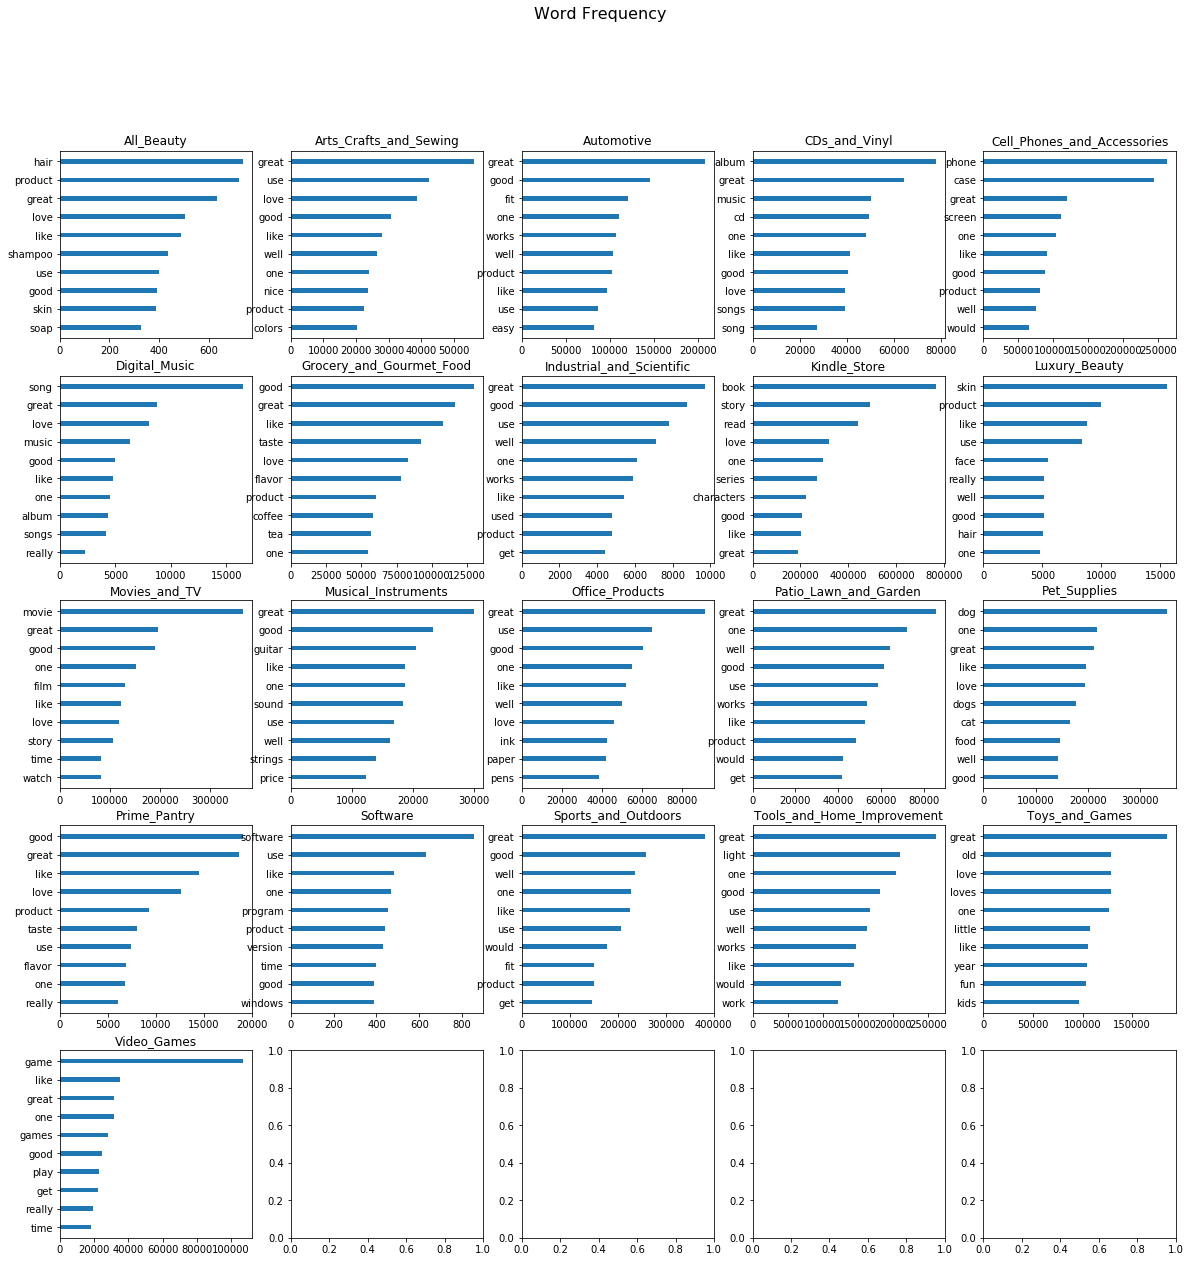

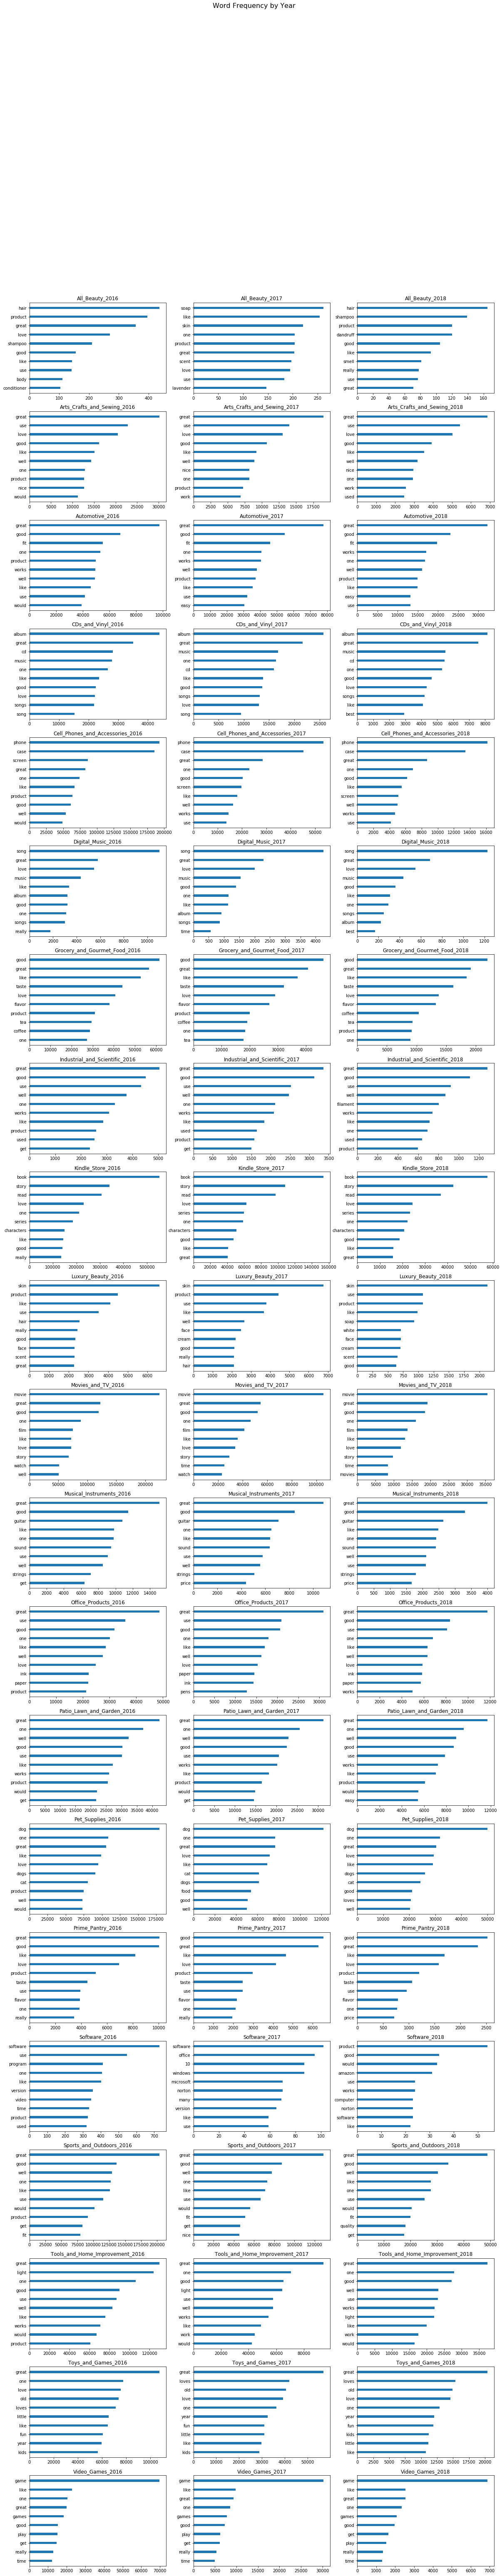

In [17]:
dep_len_w = {}
data_bym = pd.DataFrame(columns=['reviewTime'])

fig_total, ax_total = plt.subplots(5,5, figsize=(20, 20))
fig_total.suptitle('Word Frequency', fontsize=16)

fig_year, ax_year = plt.subplots(21,3, figsize=(20, 100))
fig_year.suptitle('Word Frequency by Year', fontsize=16)
for i in range(len(filelist)):
# for i in range(2):
    with open('data/' + filelist[i] + '.json') as f:
        print("Reading " + filelist[i] + "...")
        data = readJson(f)
        dep_len_w[filelist[i]] = data.shape[0]
        
        # month level - length
        print("Processing monthly data for " + filelist[i] + "...")
        
        data['reviewTime'] = data['reviewTime'].dt.to_period('M')
        data = data.groupby('reviewTime').reviewText.agg(['sum','count']).reset_index().rename(columns = {'sum':'reviewText'})
        data['reviewText'] = data[['reviewText']] .applymap(removePuncLower)
        data['reviewText'] = data[['reviewText']].applymap(word_tokenize)
        data["len_comments"] = data[['reviewText']].applymap(len)
        data["len_comments"] = data["len_comments"]/data['count']
        data_bym_dep = data.drop(columns = ['reviewText','count'])
        data_bym = pd.merge(data_bym, data_bym_dep, how='outer', on='reviewTime').rename(columns = {'len_comments' : filelist[i]})
        
        # year level - word frequency
        print("Processing yearly data for " + filelist[i] + "...")
        
        data['reviewTime'] = data['reviewTime'].dt.year
        data = data.groupby('reviewTime').reviewText.agg('sum')
        text_dict = data.to_dict()
        for year in text_dict:
            freq_count = Counter(text_dict[year]).most_common(100)
            freq_count = sorted(removeStopwords_dict(freq_count), key = lambda x : x[1])[-10:]
            loc_i = i
            loc_j = year-2016
            plotFreqWords(freq_count, filelist[i] + '_' + str(year), ax_year, loc_i, loc_j)
        
        # Total - word frequency, length
        print("Processing total data for " + filelist[i] + "...")
        
        data = pd.DataFrame(data)
        text = textExtract(data)

        del data
        gc.collect()

        dep_len_w[filelist[i]] = len(text)/dep_len_w[filelist[i]]        
        freq_count = Counter(text).most_common(100)       
        freq_count = sorted(removeStopwords_dict(freq_count), key = lambda x : x[1])[-10:]
        loc_i = i // 5
        loc_j = i % 5
        plotFreqWords(freq_count, filelist[i], ax_total, loc_i, loc_j)

It is our first thought to plot the key words in each department. In this way we can have a general understanding of what people are looking and buying in the department. But in the result, we can see that many of the departments have similiar top frequent words, such as great, product, use etc. We changed our direction to tfidf after this.

We can also see from the charts that the key words in each department do change by time. This information is important for our target users( Amazon sellers or potential Amazon sellers) when they want to know the trend of the deparment and want to list their products accordingly.

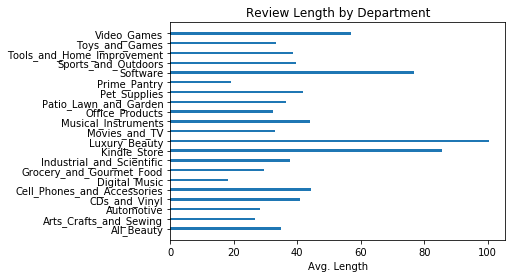

In [19]:
# ploting average comment length by department
plotReviewLength(dep_len_w)

We can see from the review length chart that virtual products like video games and software tends to have longer comments than other departments. This is reasonable because the description and photo for virtual products is not as straight-forward as other products, so customers may have different expectations for the products by reading the description only. When they receive a product which is different from what they expected, they tend to leave a review.

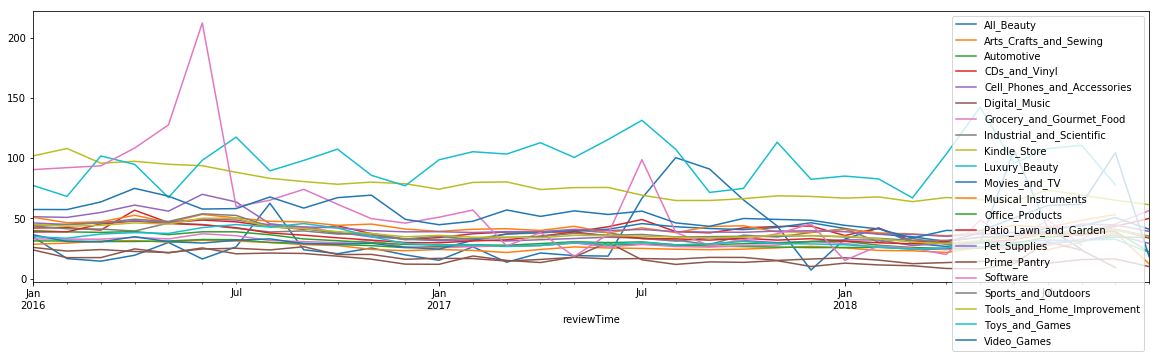

In [18]:
# ploting average comment length by month
data_bym.plot(figsize = (20,5), x = 'reviewTime')

We can see from this chart that the seasonality of each department is stable across years. Amazon sellers can choose to list their key products and offer promotions in peak season to boost sales.

### TFIDF word cloud

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

def subsetData(data, pct):
    if data.shape[0] > 500000:
        data = data.sample(frac = pct)
    return data 

def textExtract_str(data):
    data = data[data['reviewText'].notna()]
    rawtext =  ' '. join(list(data['reviewText']))
    return rawtext

def computeTFIDF(corpus, columnnames, dfmax):    
    vectorizer = TfidfVectorizer(stop_words = 'english', max_df = dfmax, use_idf = True)
    print("transforming...")
    X = vectorizer.fit_transform(corpus)
    print("getting feature name...")
    feature_names = vectorizer.get_feature_names()
    print("densing list...")
    dense = X.todense()
    denselist = dense.tolist()
    print("reshaping list...")
    new_list = [list(x) for x in zip(*denselist)]
    print("converting to data frame...")
    df = pd.DataFrame(new_list, index=feature_names, columns = columnnames)
    return df

In [ ]:
filePath = 'data'
filelist = os.listdir(filePath)
filelist.pop(-6)
for i in range(len(filelist)):
    filelist[i] = filelist[i][:-5]

In [12]:
def readJson(filePath):
#     filePath = "data/" + filePath
#     with open(filePath) as data: 
    data = json.load(filePath)
    data = pd.DataFrame(data)        
    # Convert the string time back to datetime
    data["reviewTime"] = pd.to_datetime(data.reviewTime)
    data = data[data['reviewText'].notna()]
    return data

def subsetData(data, pct):
    if data.shape[0] > 500000:
        data = data.sample(frac = pct)
    return data 

def textExtract_str(data):
    data = data[data['reviewText'].notna()]
    rawtext =  ' '. join(list(data['reviewText']))
    return rawtext

def computeTFIDF(corpus, columnnames, dfmax):    
    vectorizer = TfidfVectorizer(stop_words = 'english', max_df = dfmax, use_idf = True)
    print("transforming...")
    X = vectorizer.fit_transform(corpus)
    print("getting feature name...")
    feature_names = vectorizer.get_feature_names()
    print("densing list...")
    dense = X.todense()
    denselist = dense.tolist()
    print("reshaping list...")
    new_list = [list(x) for x in zip(*denselist)]
    print("converting to data frame...")
    df = pd.DataFrame(new_list, index=feature_names, columns = columnnames)
    return df

In [48]:
doc_list = []
for i in range(len(filelist)):
    with open('data/' + filelist[i] + '.json') as f:
        print("reading " + filelist[i] + '...')
        data = readJson(f)
        print("subseting " + filelist[i] + '...')
        data = subsetData(data, 0.1)
        print("processing " + filelist[i] + '...')
        text = textExtract_str(data)
        text = removePuncLower(text)
        doc_list.append(text)

reading All_Beauty...
subseting All_Beauty...
processing All_Beauty...
reading Arts_Crafts_and_Sewing...
subseting Arts_Crafts_and_Sewing...
processing Arts_Crafts_and_Sewing...
reading Automotive...
subseting Automotive...
processing Automotive...
reading CDs_and_Vinyl...
subseting CDs_and_Vinyl...
processing CDs_and_Vinyl...
reading Cell_Phones_and_Accessories...
subseting Cell_Phones_and_Accessories...
processing Cell_Phones_and_Accessories...
reading Clothing_Shoes_and_Jewelry...
subseting Clothing_Shoes_and_Jewelry...
processing Clothing_Shoes_and_Jewelry...
reading Digital_Music...
subseting Digital_Music...
processing Digital_Music...
reading Electronics...
subseting Electronics...
processing Electronics...
reading Grocery_and_Gourmet_Food...
subseting Grocery_and_Gourmet_Food...
processing Grocery_and_Gourmet_Food...
reading Home_and_Kitchen...
subseting Home_and_Kitchen...
processing Home_and_Kitchen...
reading Industrial_and_Scientific...
subseting Industrial_and_Scientific..

In [79]:
tfidf_df = computeTFIDF(doc_list, filelist, 0.99)

transforming...
getting feature name...
densing list...
reshaping list...
converting to data frame...


In [86]:
from wordcloud import WordCloud

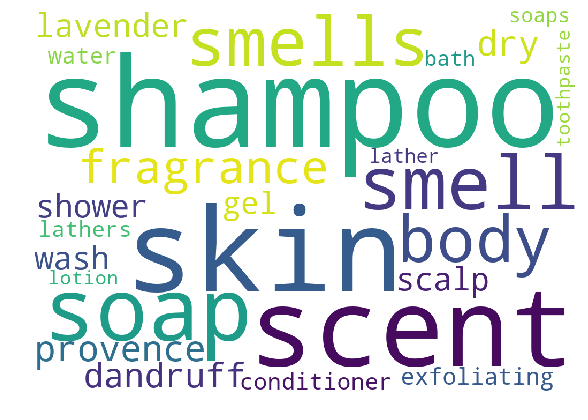

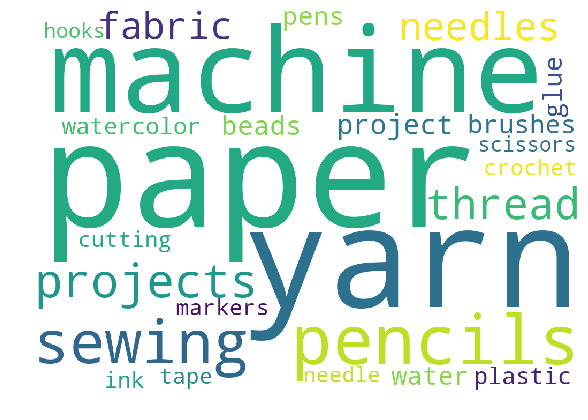

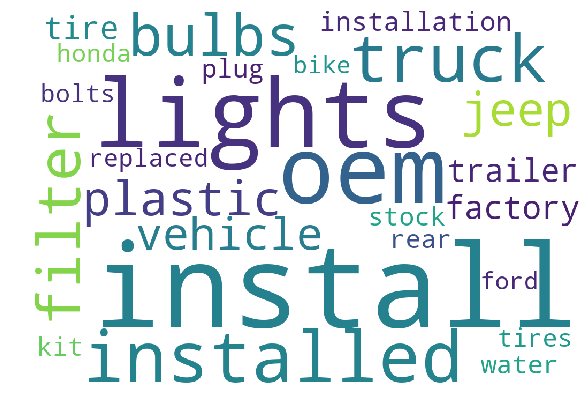

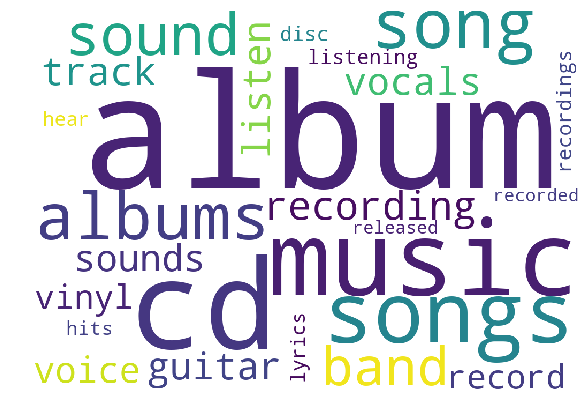

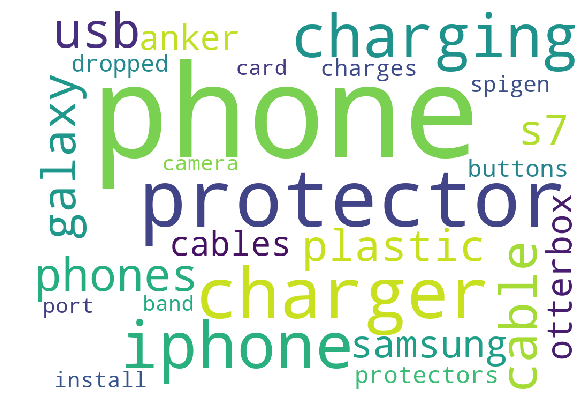

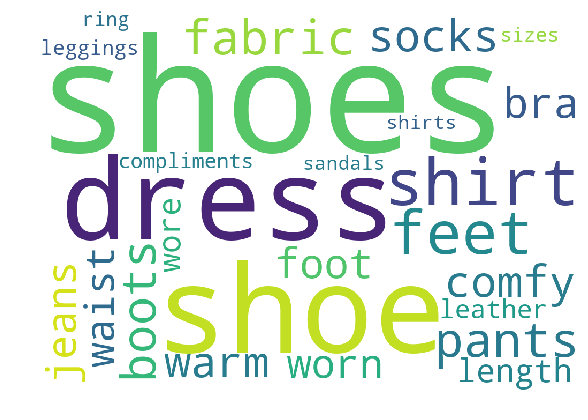

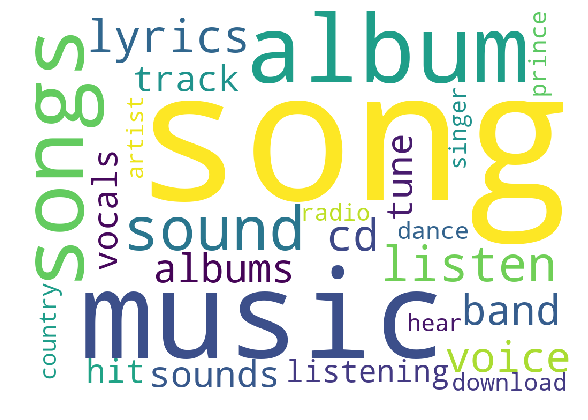

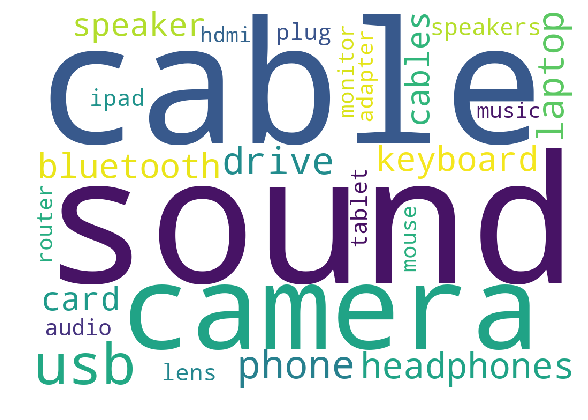

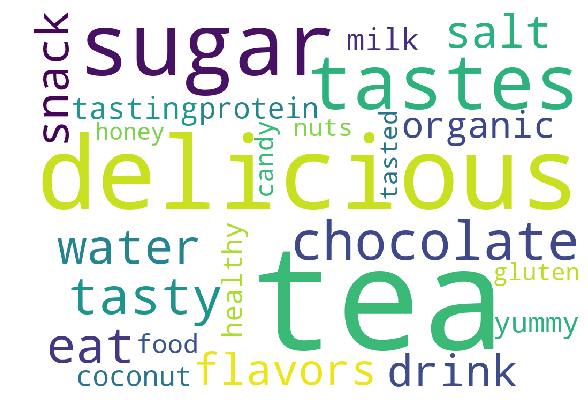

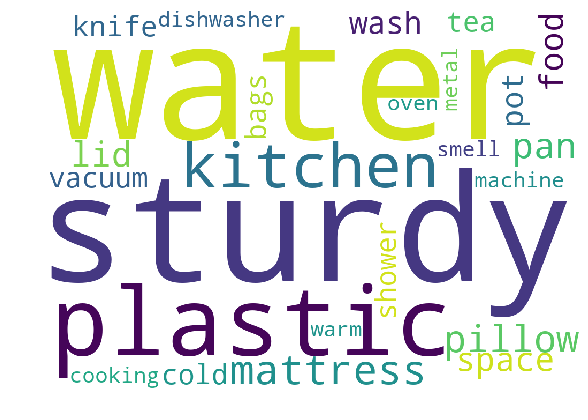

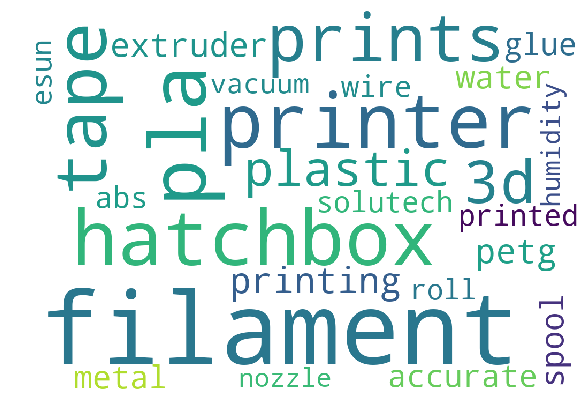

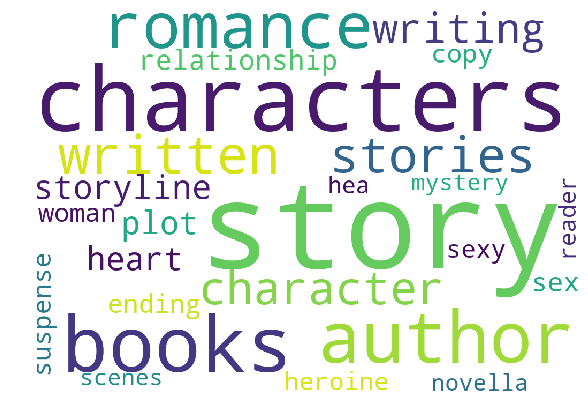

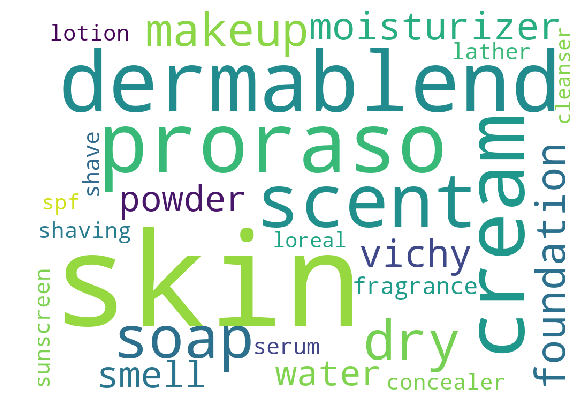

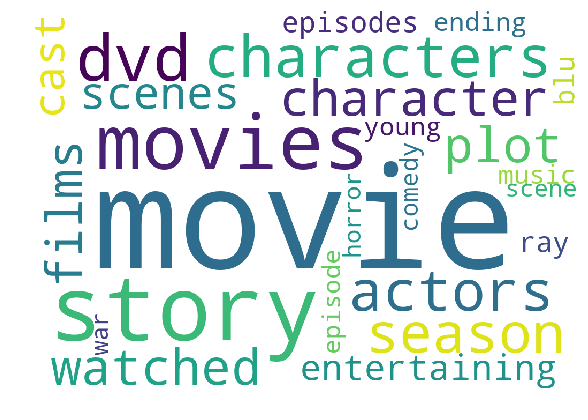

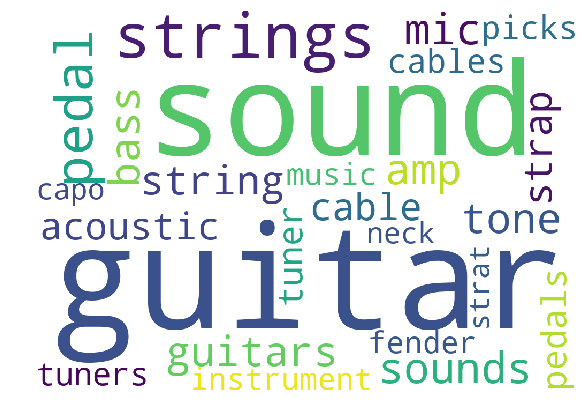

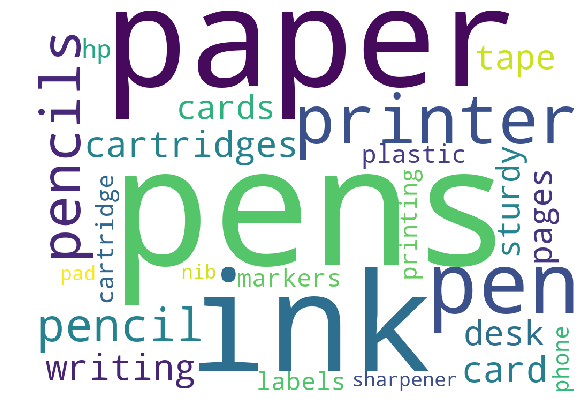

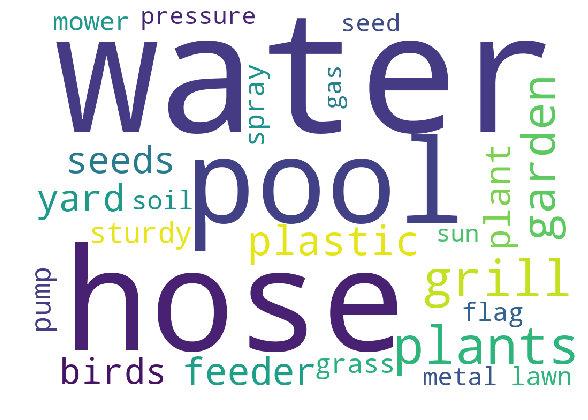

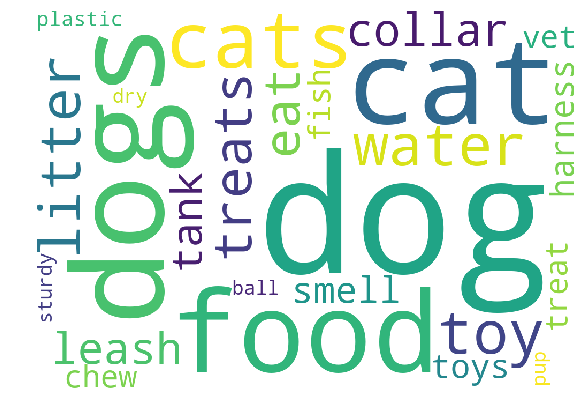

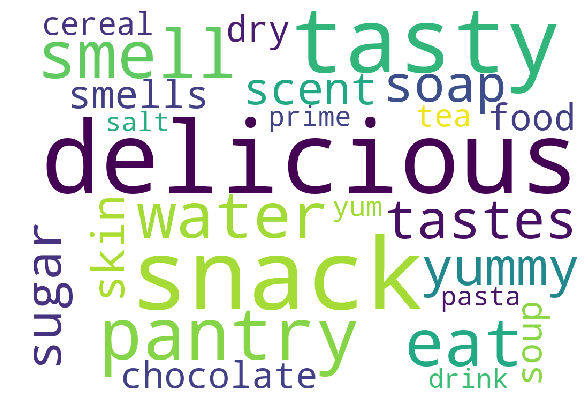

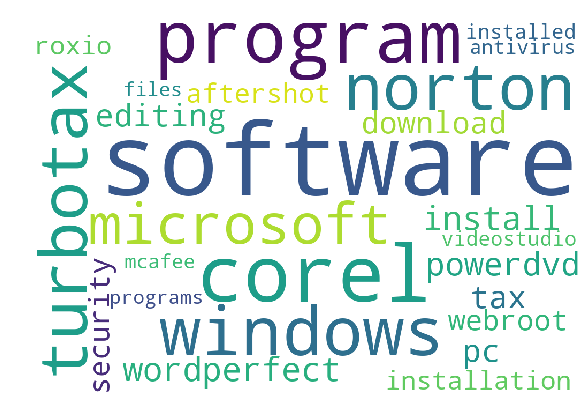

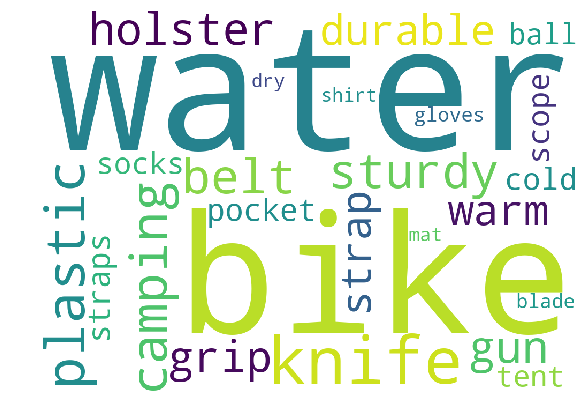

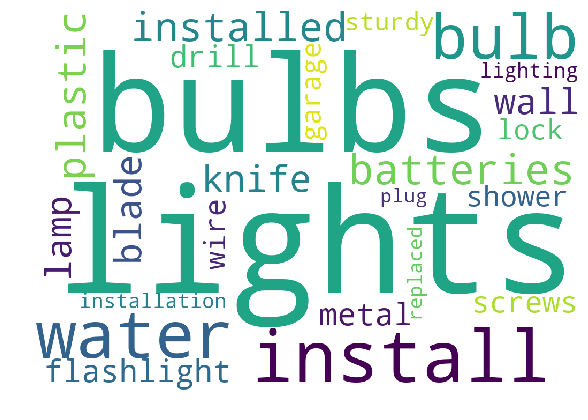

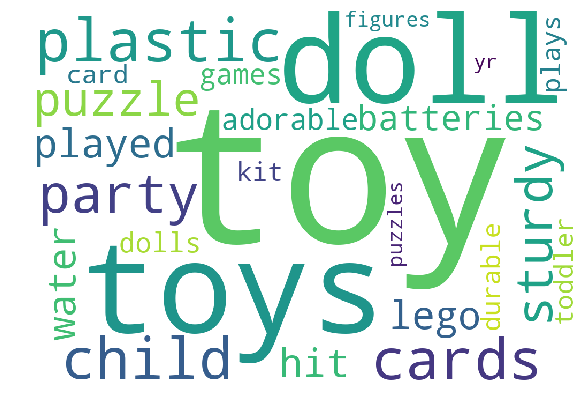

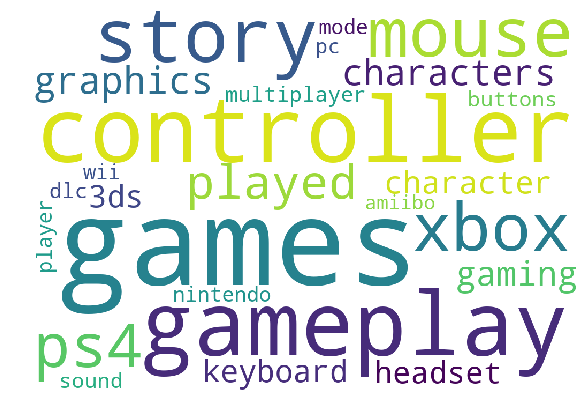

In [94]:
# fig_total, ax_total = plt.subplots(5,5, figsize=(20, 20))
# fig_total.suptitle('Word Cloud', fontsize=16)

for i in range(len(filelist)):
    top10 = tfidf_df[filelist[i]].nlargest(25).index
    top10value = list(tfidf_df[filelist[i]].nlargest(25))
    weights = {top10[i]:top10value[i] for i in range(25)}
    wc = WordCloud(
            background_color="white",
            max_words=2000,
            width = 1024,
            height = 720,
            stopwords=stopwords.words("english"))
    wc.generate_from_frequencies(weights)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
#     loc_i = i // 5
#     loc_j = i % 5
#     plotFreqWords(top10, top10value, filelist[i], ax_total, loc_i, loc_j)

We can see a huge difference between the key words based on TFIDF and the key words charts before. In the word cloud, there's no duplicated key words accross departments and the frequent words make more sense now. We decided to go with this version in our user interface.